In [1]:
import numpy as np
import sys,os
import matplotlib.pyplot as plt
from scipy.stats import multivariate_t as mvt 
import sklearn
from sklearn.covariance import GraphicalLasso
import scipy
from sklearn.metrics import zero_one_loss
from sklearn.metrics.pairwise import pairwise_kernels
import time
import tqdm
import networkx as nx

sys.path.insert(0, 'C:/Users/User/Code/DyGraph')

import DyGraph as dg
import pickle
from sklearn.datasets import make_sparse_spd_matrix
from utils import calc_one_zero_error, calc_f1, calc_precision, calc_recall, calc_density, calc_roc_auc, calc_balanced_accuaray

In [2]:
def add_stuff(out_dict):
    out_dict['f1_n'] = {i: [] for i in range(len(out_dict['theta_n']))}
    out_dict['f1_t'] = {i: [] for i in range(len(out_dict['theta_n']))}
    for i in range(len(out_dict['theta_n'])):
        for j in range(len(out_dict['theta_n'][0])):
            out_dict['f1_n'][i].append(np.mean([calc_f1(out_dict['prec'], out_dict['theta_n'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))
            out_dict['f1_t'][i].append(np.mean([calc_f1(out_dict['prec'], out_dict['theta_t'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))

    out_dict['prec_n'] = {i: [] for i in range(len(out_dict['theta_n']))}
    out_dict['prec_t'] = {i: [] for i in range(len(out_dict['theta_n']))}
    for i in range(len(out_dict['theta_n'])):
        for j in range(len(out_dict['theta_n'][0])):
            out_dict['prec_n'][i].append(np.mean([calc_precision(out_dict['prec'], out_dict['theta_n'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))
            out_dict['prec_t'][i].append(np.mean([calc_precision(out_dict['prec'], out_dict['theta_t'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))

    out_dict['recall_n'] = {i: [] for i in range(len(out_dict['theta_n']))}
    out_dict['recall_t'] = {i: [] for i in range(len(out_dict['theta_n']))}
    for i in range(len(out_dict['theta_n'])):
        for j in range(len(out_dict['theta_n'][0])):
            out_dict['recall_n'][i].append(np.mean([calc_recall(out_dict['prec'], out_dict['theta_n'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))
            out_dict['recall_t'][i].append(np.mean([calc_recall(out_dict['prec'], out_dict['theta_t'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))

    out_dict['bal_acc_n'] = {i: [] for i in range(len(out_dict['theta_n']))}
    out_dict['bal_acc_t'] = {i: [] for i in range(len(out_dict['theta_n']))}
    for i in range(len(out_dict['theta_n'])):
        for j in range(len(out_dict['theta_n'][0])):
            out_dict['bal_acc_n'][i].append(np.mean([calc_balanced_accuaray(out_dict['prec'], out_dict['theta_n'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))
            out_dict['bal_acc_t'][i].append(np.mean([calc_balanced_accuaray(out_dict['prec'], out_dict['theta_t'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))

    out_dict['auc_n'] = {i: [] for i in range(len(out_dict['theta_n']))}
    out_dict['auc_t'] = {i: [] for i in range(len(out_dict['theta_n']))}
    for i in range(len(out_dict['theta_n'])):
        for j in range(len(out_dict['theta_n'][0])):
            out_dict['auc_n'][i].append(np.mean([calc_roc_auc(out_dict['prec'], out_dict['theta_n'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))
            out_dict['auc_t'][i].append(np.mean([calc_roc_auc(out_dict['prec'], out_dict['theta_t'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))

    return out_dict

In [3]:

prec_0 = make_sparse_spd_matrix(5, alpha=0.3, smallest_coef=-0.8, largest_coef=0.8, norm_diag = True,random_state=42)
print(np.linalg.cond(prec_0))
tmp = prec_0.copy()
np.fill_diagonal(tmp,0)
G = nx.from_numpy_array(tmp)
print(nx.density(G))
print("precision")
print(prec_0)
print("Covariance")
S = np.linalg.inv(prec_0)
print(S)

6.873146230266047
0.5
precision
[[ 1.          0.          0.57121121  0.         -0.55552694]
 [ 0.          1.          0.          0.52537616 -0.17939073]
 [ 0.57121121  0.          1.          0.         -0.61932666]
 [ 0.          0.52537616  0.          1.          0.        ]
 [-0.55552694 -0.17939073 -0.61932666  0.          1.        ]]
Covariance
[[ 1.65961574  0.1450552  -0.58543137 -0.07620855  0.58540955]
 [ 0.1450552   1.50127241  0.21712451 -0.78873274  0.48436743]
 [-0.58543137  0.21712451  1.87709908 -0.11407204  0.87626474]
 [-0.07620855 -0.78873274 -0.11407204  1.41438138 -0.2544751 ]
 [ 0.58540955  0.48436743  0.87626474 -0.2544751   1.95479592]]


# MVT vs Gaussian -Erdos-Renyi precision matrix

 Test

In [10]:

d, p = 50, 0.1
G =nx.erdos_renyi_graph(d, p, seed=42)
A = np.array(nx.adjacency_matrix(G).todense())
A[np.tril_indices(d)] = 0
A = np.multiply(A, np.random.uniform(-0.4,0.4, size = (50,50)))
A = A+A.T
np.fill_diagonal(A, np.sum(np.abs(A),axis=1))
prec = A

alphas = [0.45]#np.linspace(0.01, 0.2, 5)
kappas = [0.5]#np.linspace(0.01, 0.6, 5)
tol = 1e-10


prec = A
tmp = prec.copy()
np.fill_diagonal(tmp,0)
G = nx.from_numpy_array(tmp)
print(nx.density(G))
print("\n")
nus = [4]

obs_per_graphs = [100]
for n_idx, n in enumerate([1000 ]):
    print(n)

    obs_per_graph = obs_per_graphs[n_idx]

    # pbar = tqdm.tqdm(total = len(alphas)*len(kappas)*len(nus))

    for nu in nus:
        X1 = mvt.rvs(shape = np.linalg.inv(prec),  df = nu, size = n) # np.random.multivariate_normal(mean = np.zeros(prec.shape[0]),cov = np.linalg.inv(prec), size = n)
        X = X1
        prec_dict ={}

        dens_t = {i: [] for i in range(len(kappas))}
        time_t = {i: [] for i in range(len(kappas))}
        F_t = {i: [] for i in range(len(kappas))}
        f1_t = {i: [] for i in range(len(kappas))}
        zo_t = {i: [] for i in range(len(kappas))}
        l1_t = {i: [] for i in range(len(kappas))}
        theta_t = {i: [] for i in range(len(kappas))}

        dens_n = {i: [] for i in range(len(kappas))}
        time_n = {i: [] for i in range(len(kappas))}
        F_n = {i: [] for i in range(len(kappas))}
        zo_n = {i: [] for i in range(len(kappas))}
        l1_n = {i: [] for i in range(len(kappas))}
        f1_n = {i: [] for i in range(len(kappas))}
        theta_n = {i: [] for i in range(len(kappas))}

        for i, kappa in enumerate(kappas):
            for alpha in alphas:



                start = time.time()
                dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 10000, lamda = obs_per_graph*alpha, kappa = obs_per_graph*kappa, tol = tol)
                dg_opt1.fit(X, nr_workers=10, temporal_penalty="element-wise", lik_type="t", nr_em_itr = 5, time_index=range(X.shape[0]), nu = nu, em_tol = 1e-10, verbose =True)
                elapsed = time.time()-start
                dens_t[i].append(nx.density(G))
                time_t[i].append(elapsed)
                theta_t[i].append(dg_opt1.theta)

                zo_t[i].append(np.mean([calc_one_zero_error(prec, dg_opt1.theta[k]) for k in range(len(dg_opt1.theta))]))
                F_t[i].append(np.mean([scipy.linalg.norm(prec-dg_opt1.theta[k], ord = 'fro')/scipy.linalg.norm(prec, ord = 'fro') for k in range(len(dg_opt1.theta))]))
                l1_t[i].append(np.mean([scipy.linalg.norm(prec-dg_opt1.theta[k], ord = 1)/scipy.linalg.norm(prec, ord = 1) for k in range(len(dg_opt1.theta))]))
                f1_t[i].append(np.mean([calc_f1(prec, dg_opt1.theta[k]) for k in range(len(dg_opt1.theta))]))

                start = time.time()
                dg_opt_n = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 10000, lamda = obs_per_graph*alpha, kappa = obs_per_graph*kappa, tol = tol)
                dg_opt_n.fit(X, nr_workers=10, temporal_penalty="element-wise", lik_type="gaussian", time_index=range(X.shape[0]), verbose =True)
                elapsed = time.time()-start
                dens_n[i].append(nx.density(G))
                time_n[i].append(elapsed)
                theta_n[i].append(dg_opt_n.theta)

                zo_n[i].append(np.mean([calc_one_zero_error(prec, dg_opt_n.theta[k]) for k in range(len(dg_opt_n.theta))]))
                F_n[i].append(np.mean([scipy.linalg.norm(prec-dg_opt_n.theta[k], ord = 'fro')/scipy.linalg.norm(prec, ord = 'fro') for k in range(len(dg_opt_n.theta))]))
                l1_n[i].append(np.mean([scipy.linalg.norm(prec-dg_opt_n.theta[k], ord = 1)/scipy.linalg.norm(prec, ord = 1) for k in range(len(dg_opt_n.theta))]))
                f1_n[i].append(np.mean([calc_f1(prec, dg_opt_n.theta[k]) for k in range(len(dg_opt_n.theta))]))
                # pbar.update()

            out_dict = {'nr_obs_per_graph':obs_per_graph, 'n':n, 'temporal_penalty':'global-reconstruction', 'prec':prec,
            'density_t':dens_t, 'tol':tol, 'time_t':time_t, 'zo_t':zo_t, 'F_t':F_t, 'l1_t':l1_t, 'theta_t':theta_t, 'f1_t':f1_t,
            'density_n':dens_n,  'time_n':time_n, 'zo_n':zo_n, 'F_n':F_n, 'l1_n':l1_n, 'theta_n':theta_n, 'f1_n':f1_n,
            'alpha':alphas, 'kappa':kappas, 'max_iter':5000} 

            # import pickle
            # with open(f'../data/distributions/mvt_gaussian_search_d_{d}_n_{n}_s_{alpha_prob}_nu_{nu}.pkl', 'wb') as handle:
            #     pickle.dump(out_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

C:\Users\User\AppData\Local\Temp\ipykernel_8632\534129029.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = np.array(nx.adjacency_matrix(G).todense())


0.09795918367346938


1000


Error 5.59E+0:  13%|█▎        | 1276/10000 [00:19<02:05, 69.59it/s]

KeyboardInterrupt: 

Error 5.59E+0:  13%|█▎        | 1277/10000 [00:30<02:05, 69.59it/s]

In [3]:
nu = 4
all_dicts = []
for s in [0.1, 0.2, 0.3, 0.4]:
    with open(f'../data/distributions/mvt_gaussian_search_d_50_n_1000_s_{s}_nu_4_erdos.pkl', 'rb') as handle:
        all_dicts.append(pickle.load(handle))


for i in range(len(all_dicts)):
    all_dicts[i] = add_stuff(all_dicts[i])

c:\Users\User\anaconda3\envs\DyGraph\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\envs\DyGraph\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\envs\DyGraph\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\envs\DyGraph\lib\site-packages\sklearn\metrics\_classifica

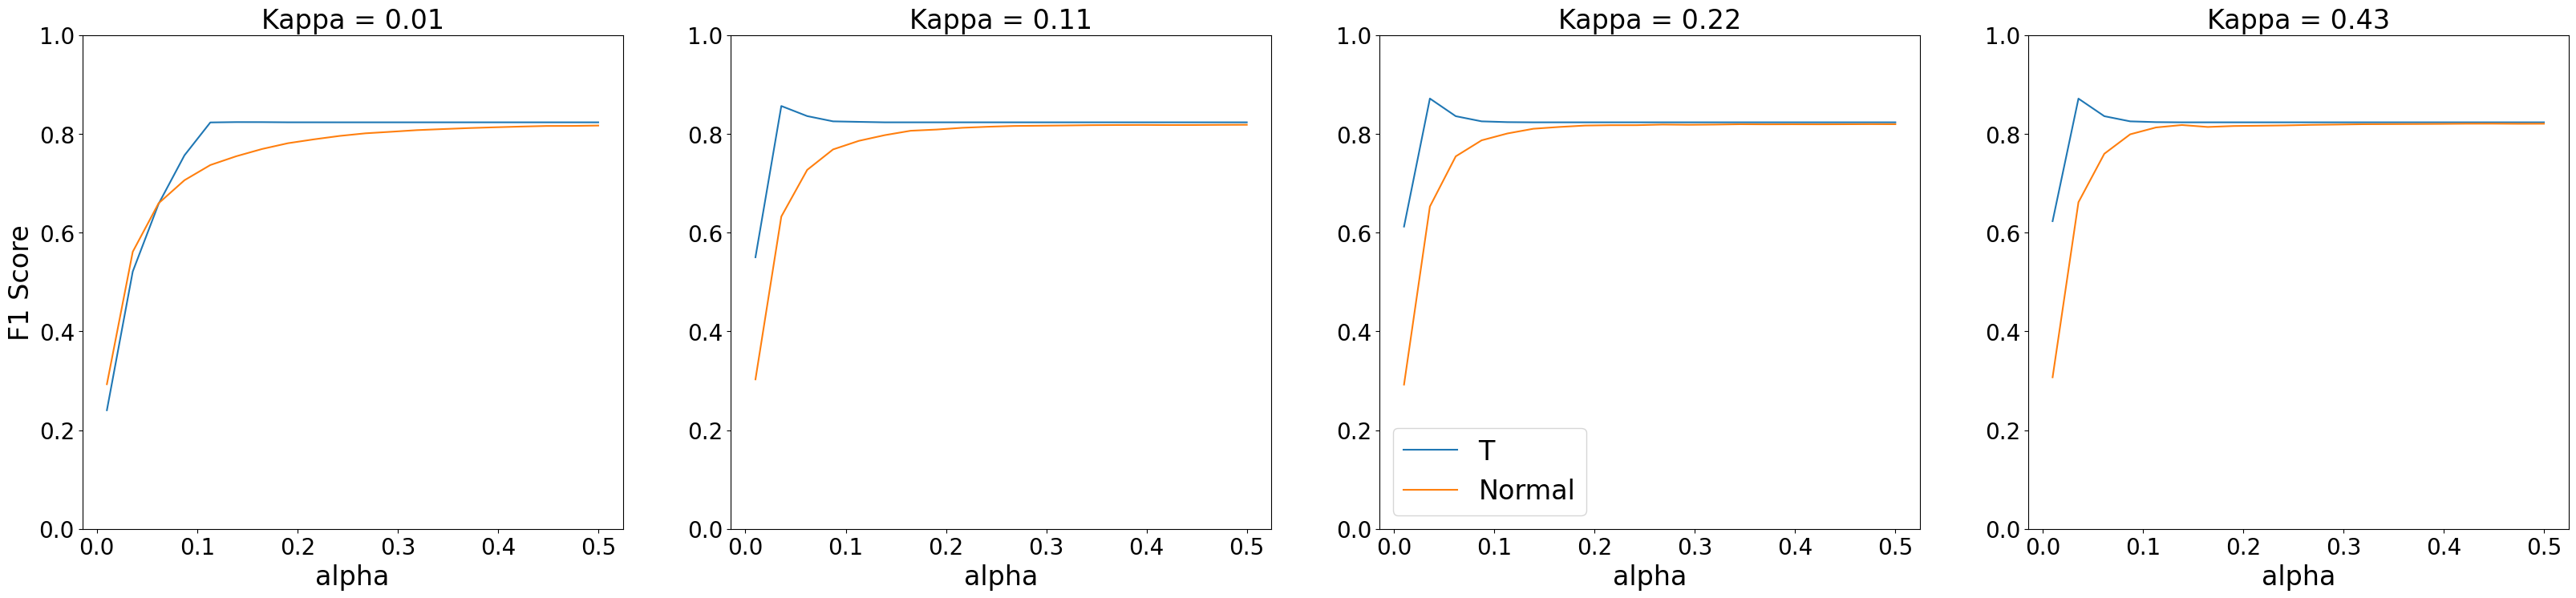

In [11]:
fig, ax = plt.subplots(1,4, figsize = (40,8))
out_dict = all_dicts[2]
for i,k_idx in enumerate([0,1,2,4]):

    ax[i].plot(out_dict['alpha'],out_dict['f1_t'][k_idx], label = 'T')
    ax[i].plot(out_dict['alpha'],out_dict['f1_n'][k_idx], label = 'Normal')
    ax[i].tick_params(axis='both', which='major', labelsize=20)

    # ax[i].plot(out_dict['alpha'],out_dict['prec_t'][k_idx], label = 'T precision', color = 'blue', linestyle = 'dashed')
    # ax[i].plot(out_dict['alpha'],out_dict['prec_n'][k_idx], label = 'Normal, precision', color = 'red', linestyle = 'dashed')

    # ax[i].plot(out_dict['alpha'],out_dict['recall_t'][k_idx], label = 'T recall', color = 'blue')
    # ax[i].plot(out_dict['alpha'],out_dict['recall_n'][k_idx], label = 'Normal recall', color = 'red')

    #ax.plot(out_dict['alpha'],out_dict['bal_acc_t'][k_idx], label = 'T bal. acc.', color = 'blue', linestyle = (0, (3, 5, 1, 5, 1, 5)))
    #ax.plot(out_dict['alpha'],out_dict['bal_acc_n'][k_idx], label = 'Normal bal. acc.', color = 'red', linestyle = (0, (3, 5, 1, 5, 1, 5)))

    #ax[i].plot(out_dict['alpha'],out_dict['auc_t'][k_idx], label = 'T auc', color = 'blue')
    #ax[i].plot(out_dict['alpha'],out_dict['auc_n'][k_idx], label = 'Normal auc', color = 'red')

    ax[i].set_xlabel("alpha", fontdict= {'fontsize':24})
    if i == 0:
        ax[i].set_ylabel("F1 Score", fontdict= {'fontsize':24})
    ax[i].set_title(f"Kappa = {np.round(out_dict['kappa'][k_idx],2)}", fontdict = {'fontsize':24})
    ax[i].set_ylim([0,1])

    if i == 3-1:
        legend  = ax[i].legend(title = "",fontsize = 24)
        legend.get_title().set_fontsize('24')

# MVT - MVT vs Gaussian

In [4]:
ds = [5, 10, 50, 100]
alpha_prob = [0.03, 0.15, 0.8, 0.9] #[0.03, 0.15, 0.5, 0.7, 0.8, 0.9, 0.95, 0.97, 0.99 ]
alpha = 0.05
kappa = 0.1
tol = 1e-10
n = 1000
obs_per_graph = 100
prec_dict ={}

dens_inner = []
time_inner = []
F_inner = []
zo_inner = []
l1_inner = []

dens_outer = []
time_outer = []
F_outer = []
zo_outer = []
l1_outer = []


for i,d in enumerate(ds):
    print(d)

    prec = make_sparse_spd_matrix(d, alpha=alpha_prob[i], smallest_coef=-0.9, largest_coef=0.9, norm_diag = True, random_state = 42)
    tmp = prec.copy()
    np.fill_diagonal(tmp,0)
    G = nx.from_numpy_array(tmp)
    print(nx.density(G))
    print("\n")

    prec_dict[i] = prec


    X1 = mvt.rvs(shape = np.linalg.inv(prec),  df = 4, size = n) # np.random.multivariate_normal(mean = np.zeros(prec.shape[0]),cov = np.linalg.inv(prec), size = n)
    X = X1

    start = time.time()
    dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 10000, lamda = obs_per_graph*alpha, kappa = obs_per_graph*kappa, tol = tol)
    dg_opt1.fit(X, nr_workers=1, temporal_penalty="element-wise", lik_type="t", nr_em_itr = 1, time_index=range(X.shape[0]), nu = 4, em_tol = 1e-6)
    elapsed = time.time()-start
    dens_inner.append(nx.density(G))
    time_inner.append(elapsed)

    zo_inner.append(np.mean([calc_one_zero_error(prec, dg_opt1.theta[k]) for k in range(len(dg_opt1.theta))]))
    F_inner.append(np.mean([scipy.linalg.norm(prec-dg_opt1.theta[k], ord = 'fro')/scipy.linalg.norm(prec, ord = 'fro') for k in range(len(dg_opt1.theta))]))
    l1_inner.append(np.mean([scipy.linalg.norm(prec-dg_opt1.theta[k], ord = 1)/scipy.linalg.norm(prec, ord = 1) for k in range(len(dg_opt1.theta))]))
        
    start = time.time()
    dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 10000, lamda = obs_per_graph*alpha, kappa = obs_per_graph*kappa, tol = tol)
    dg_opt1.fit(X, nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian", time_index=range(X.shape[0]))
    elapsed = time.time()-start
    dens_outer.append(nx.density(G))
    time_outer.append(elapsed)

    zo_outer.append(np.mean([calc_one_zero_error(prec, dg_opt1.theta[k]) for k in range(len(dg_opt1.theta))]))
    F_outer.append(np.mean([scipy.linalg.norm(prec-dg_opt1.theta[k], ord = 'fro')/scipy.linalg.norm(prec, ord = 'fro') for k in range(len(dg_opt1.theta))]))
    l1_outer.append(np.mean([scipy.linalg.norm(prec-dg_opt1.theta[k], ord = 1)/scipy.linalg.norm(prec, ord = 1) for k in range(len(dg_opt1.theta))]))

out_dict = {'nr_obs_per_graph':obs_per_graph, 'n':n, 'temporal_penalty':'global-reconstruction', 
'density_inner':dens_inner, 'tol':tol, 'time_inner':time_inner, 'zo_inner':zo_inner, 'F_inner':F_inner, 'l1_inner':l1_inner,
'density_outer':dens_outer, 'tol':tol, 'time_outer':time_outer, 'zo_outer':zo_outer, 'F_inner':F_outer, 'l1_inner':l1_outer,
'ds':ds, 'alpha':alpha, 'kappa':kappa, 'max_iter':5000} 
    
import pickle
with open(f'../distributions/mvt_mvt_gaussian.pkl', 'wb') as handle:
    pickle.dump(out_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


5
0.9




  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users/User/Code/DyGraph\DyGraph\dygl_parallel.py:109: UserWarning: EM algorithm did not converge. Try to increase number of iterations
  warnings.warn("EM algorithm did not converge. Try to increase number of iterations")
Error 1.07E-10:   2%|▏         | 210/10000 [00:00<00:14, 694.53it/s]


10
0.8888888888888888




Error 1.01E-10:   8%|▊         | 845/10000 [00:01<00:14, 646.46it/s]


50
0.5559183673469388




Error 7.30E-3:   1%|          | 96/10000 [00:01<02:13, 74.04it/s]

KeyboardInterrupt: 

In [ ]:


fig, ax = plt.subplots(1,2, figsize = (14,5))

ax[0].plot(ds, time_inner, label  = 'Inner EM')
ax[0].plot(ds, time_outer, label  = 'Outer EM')
ax[0].set_xlabel("Dimension", fontdict = {'fontsize':24})
ax[0].set_ylabel("Seconds", fontdict = {'fontsize':24})
ax[0].tick_params(axis='both', which='major', labelsize=20)
#ax[0].set_xticks(0])
legend = ax[0].legend(fontsize = 14)
legend.get_title().set_fontsize('18')

ax[1].plot(ds,l1_inner, label ='l1 Inner', color = "darkblue", alpha = 0.5)
ax[1].plot(ds,l1_outer, label ='l1 Outer', color = "darkblue", linestyle = 'dashed')
ax[1].plot(ds,F_inner, label ='Frobenius Inner', color = "red", alpha = 0.5)
ax[1].plot(ds,F_outer, label ='Frobenius Outer', color = "red", linestyle = 'dashed')
ax[1].plot(ds,zo_inner, label ='One-Zero Inner', color = "darkgreen", alpha = 0.5)
ax[1].plot(ds,zo_outer, label ='One-Zero Outer', color = "darkgreen", linestyle = 'dashed')
#ax[1].plot(nr_admm_its,[np.mean(zo_error[i]) for i in range(len(zo_error))], label ='Zero-One')
#ax[1].plot(nr_admm_its,[np.mean(f_error[i]) for i in range(len(f_error))], label ='Frobenius')
legend = ax[1].legend(title = "Metric",fontsize = 14, bbox_to_anchor = (1.05,1))
legend.get_title().set_fontsize('18')
ax[1].set_xlabel("Nr. inner ADMM iterations", fontdict = {'fontsize':24})
ax[1].set_ylabel("Error", fontdict = {'fontsize':24})
ax[1].tick_params(axis='both', which='major', labelsize=20)
# ax[1].set_xticks([0,5, 10, 15])


 Fix and search

In [2]:
d = 25
alpha_prob =  0.5 #[0.03, 0.15, 0.5, 0.7, 0.8, 0.9, 0.95, 0.97, 0.99 ]
alphas = np.linspace(0.01, 0.2, 10)
kappas = np.linspace(0.01, 0.6, 10)
tol = 1e-10
n = 1000
obs_per_graph = 100

prec1 = make_sparse_spd_matrix(d, alpha=alpha_prob, smallest_coef=-0.9, largest_coef=0.9, norm_diag = True, random_state = 42)
prec2 = make_sparse_spd_matrix(d, alpha=alpha_prob, smallest_coef=-0.9, largest_coef=0.9, norm_diag = True, random_state = 412)
prec = np.block([[prec1, np.zeros((d,d))], [np.zeros((d,d)), prec2]])
tmp = prec.copy()
np.fill_diagonal(tmp,0)
G = nx.from_numpy_array(tmp)
print(nx.density(G))
print("\n")
nus = [4]

0.4146938775510204




In [27]:
d = 50
alpha_prob =  0.8 #[0.03, 0.15, 0.5, 0.7, 0.8, 0.9, 0.95, 0.97, 0.99 ]
alphas = np.linspace(0.01, 0.2, 7)
kappas = np.linspace(0.01, 0.6, 10)
tol = 1e-10

prec1 = make_sparse_spd_matrix(d, alpha=alpha_prob, smallest_coef=-0.9, largest_coef=0.9, norm_diag = True, random_state = 42)
# prec2 = make_sparse_spd_matrix(d, alpha=alpha_prob, smallest_coef=-0.9, largest_coef=0.9, norm_diag = True, random_state = 412)
# prec = np.block([[prec1, np.zeros((d,d))], [np.zeros((d,d)), prec2]])
prec = prec1
tmp = prec.copy()
np.fill_diagonal(tmp,0)
G = nx.from_numpy_array(tmp)
print(nx.density(G))

0.5559183673469388


In [58]:
print(zo_n[0][0])
print(zo_t[0][0])
print("\n")
print(l1_n[0][0])
print(l1_t[0][0])
print("\n")
print(F_n[0][0])
print(F_t[0][0])
print("\n")
print(f1_n[0][0])
print(f1_t[0][0])
print("\n")

0.30979591836734693
0.3036734693877551


0.7370869540717123
0.5309936231276087


0.5316202150873427
0.2554812195179144


0.8122397585768921
0.8209817131857557




In [43]:
nu = 4
with open(f'../data/distributions/mvt_mvt_gaussian_search_d_50_n_10000.pkl', 'rb') as handle:
    out_dict = pickle.load(handle)




    

KeyError: 'theta_n'

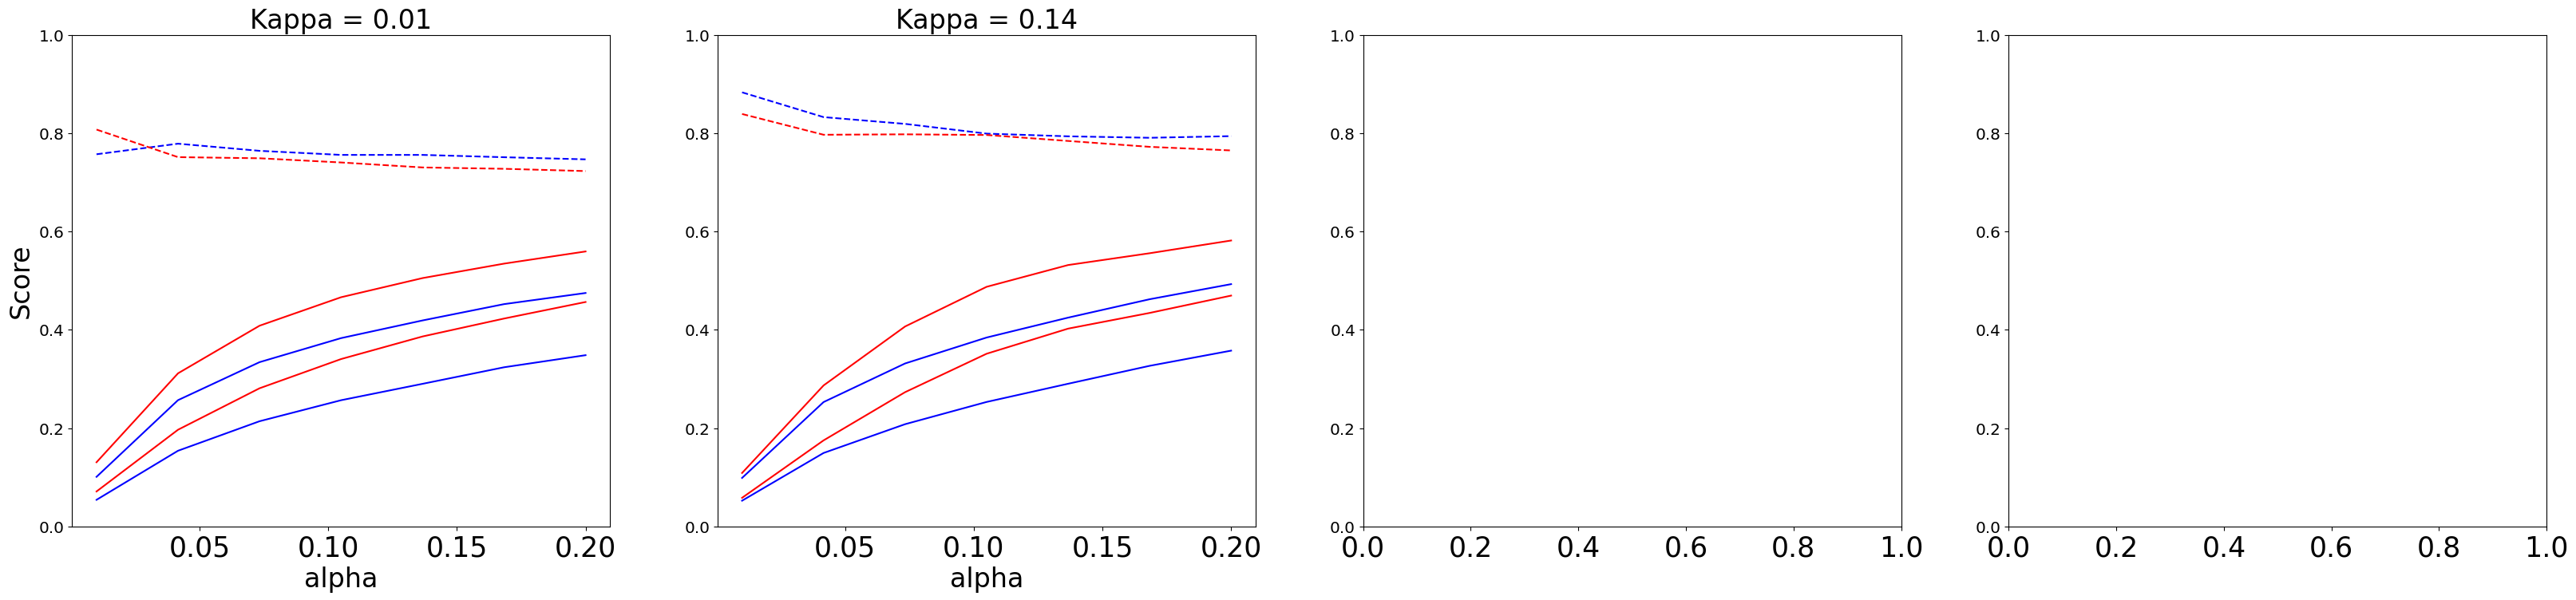

In [8]:
fig, ax = plt.subplots(1,4, figsize = (40,8))
for i,k_idx in enumerate([0,2]):

    ax[i].plot(out_dict['alpha'],out_dict['f1_t'][k_idx], label = 'T f1', color = 'blue')
    ax[i].plot(out_dict['alpha'],out_dict['f1_n'][k_idx], label = 'Normal f1', color = 'red')

    ax[i].plot(out_dict['alpha'],out_dict['prec_t'][k_idx], label = 'T precision', color = 'blue', linestyle = 'dashed')
    ax[i].plot(out_dict['alpha'],out_dict['prec_n'][k_idx], label = 'Normal, precision', color = 'red', linestyle = 'dashed')

    ax[i].plot(out_dict['alpha'],out_dict['recall_t'][k_idx], label = 'T recall', color = 'blue')
    ax[i].plot(out_dict['alpha'],out_dict['recall_n'][k_idx], label = 'Normal recall', color = 'red')

    #ax.plot(out_dict['alpha'],out_dict['bal_acc_t'][k_idx], label = 'T bal. acc.', color = 'blue', linestyle = (0, (3, 5, 1, 5, 1, 5)))
    #ax.plot(out_dict['alpha'],out_dict['bal_acc_n'][k_idx], label = 'Normal bal. acc.', color = 'red', linestyle = (0, (3, 5, 1, 5, 1, 5)))

    #ax[i].plot(out_dict['alpha'],out_dict['auc_t'][k_idx], label = 'T auc', color = 'blue')
    #ax[i].plot(out_dict['alpha'],out_dict['auc_n'][k_idx], label = 'Normal auc', color = 'red')

    ax[i].set_xlabel("alpha", fontdict= {'fontsize':24})
    if i == 0:
        ax[i].set_ylabel("Score", fontdict= {'fontsize':24})
    ax[i].set_title(f"Kappa = {np.round(out_dict['kappa'][k_idx],2)}", fontdict = {'fontsize':24})
    ax[i].set_ylim([0,1])

    if i == 4-1:
        legend  = ax[i].legend(title = "",fontsize = 18)
        legend.get_title().set_fontsize('18')

 Look at size 

In [9]:
all_dicts = []

for n in [2000, 5000, 7000, 10000, 20000, 100000]:
    print(n)
    with open(f'../data/distributions/mvt_gaussian_search_d_50_n_{n}_s_0.8_nu_4.pkl', 'rb') as handle:
        out_dict = pickle.load(handle)
        out_dict = add_stuff(out_dict)
        all_dicts.append(out_dict)


2000
5000
7000
10000
20000
100000


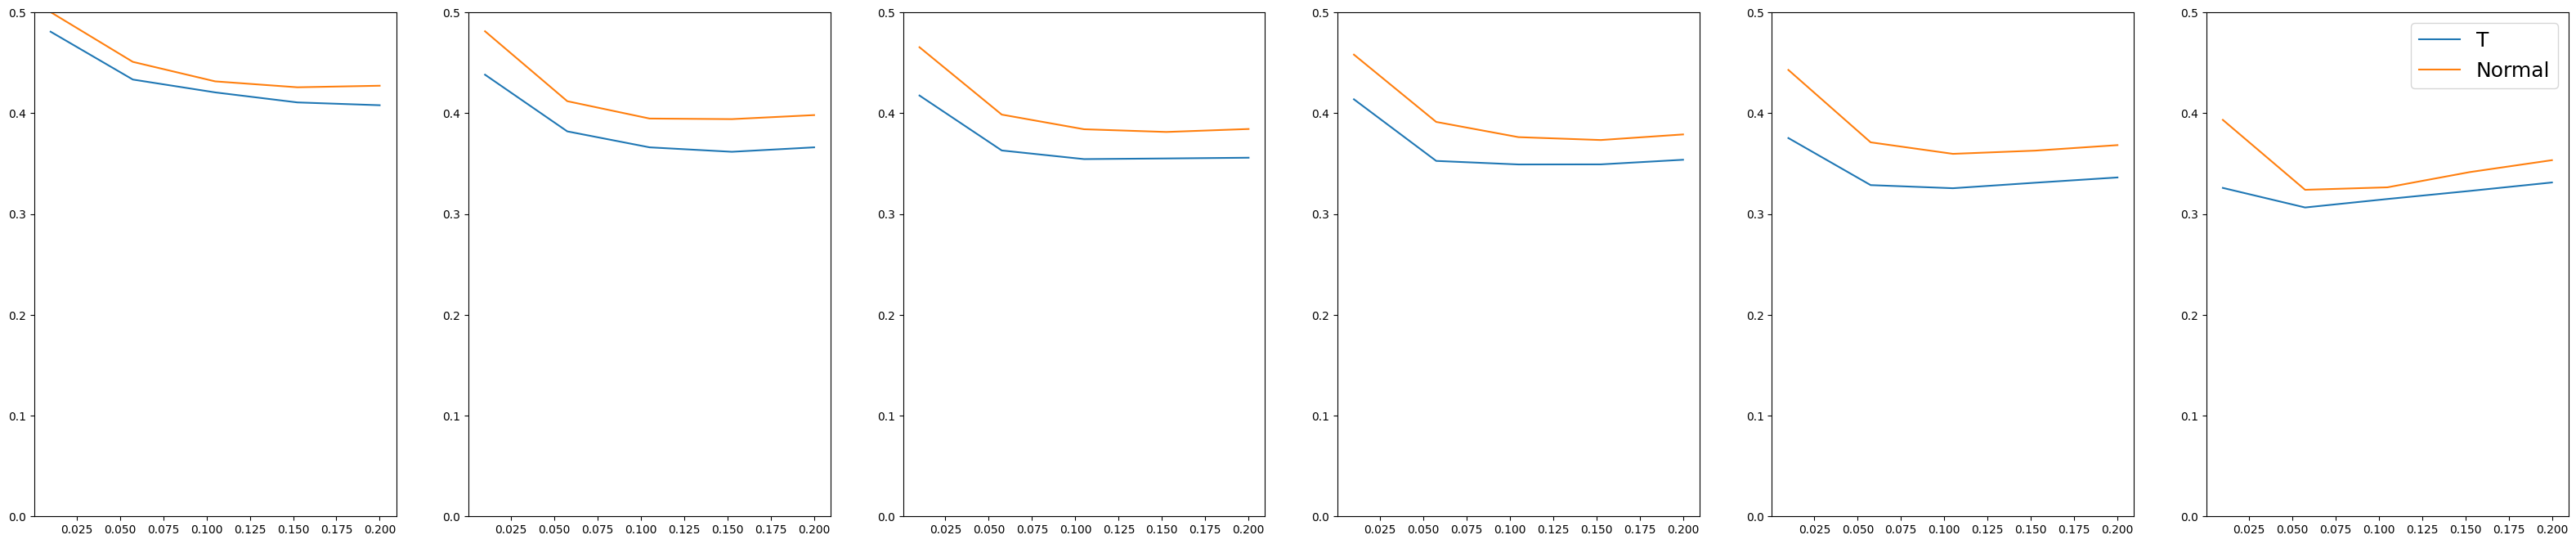

In [17]:

fig, ax = plt.subplots(1,6, figsize = (40,8))

k_idx = 0
#ax[i].plot(out_dict['alpha'],out_dict['f1_t'][k_idx], label = 'T f1', color = 'blue')
#ax[i].plot(out_dict['alpha'],out_dict['f1_n'][k_idx], label = 'Normal f1', color = 'red')

for i in range(6):
    ax[i].plot(all_dicts[i]['alpha'],all_dicts[i]['zo_t'][k_idx], label = 'T')
    ax[i].plot(all_dicts[i]['alpha'],all_dicts[i]['zo_n'][k_idx], label = 'Normal')
    ax[i].set_ylim((0,0.5))

    if i == 6-1:
        legend  = ax[i].legend(title = "",fontsize = 18)
        legend.get_title().set_fontsize('18')

# ax[1].plot(out_dict['alpha'],out_dict['recall_t'][k_idx], label = 'T')
# ax[1].plot(out_dict['alpha'],out_dict['recall_n'][k_idx], label = 'Normal recall', color = 'red')

# ax.plot(out_dict['alpha'],out_dict['bal_acc_t'][k_idx], label = 'T bal. acc.', color = 'blue', linestyle = (0, (3, 5, 1, 5, 1, 5)))
# ax.plot(out_dict['alpha'],out_dict['bal_acc_n'][k_idx], label = 'Normal bal. acc.', color = 'red', linestyle = (0, (3, 5, 1, 5, 1, 5)))

# ax[i].plot(out_dict['alpha'],out_dict['auc_t'][k_idx], label = 'T auc', color = 'blue')
# ax[i].plot(out_dict['alpha'],out_dict['auc_n'][k_idx], label = 'Normal auc', color = 'red')

# ax[i].set_xlabel("alpha", fontdict= {'fontsize':24})
# if i == 0:
#     ax[i].set_ylabel("Score", fontdict= {'fontsize':24})
# ax[i].set_title(f"Kappa = {np.round(out_dict['kappa'][k_idx],2)}", fontdict = {'fontsize':24})
# ax[i].set_ylim([0,1])

# if i == 4-1:
#     legend  = ax[i].legend(title = "",fontsize = 18)
#     legend.get_title().set_fontsize('18')

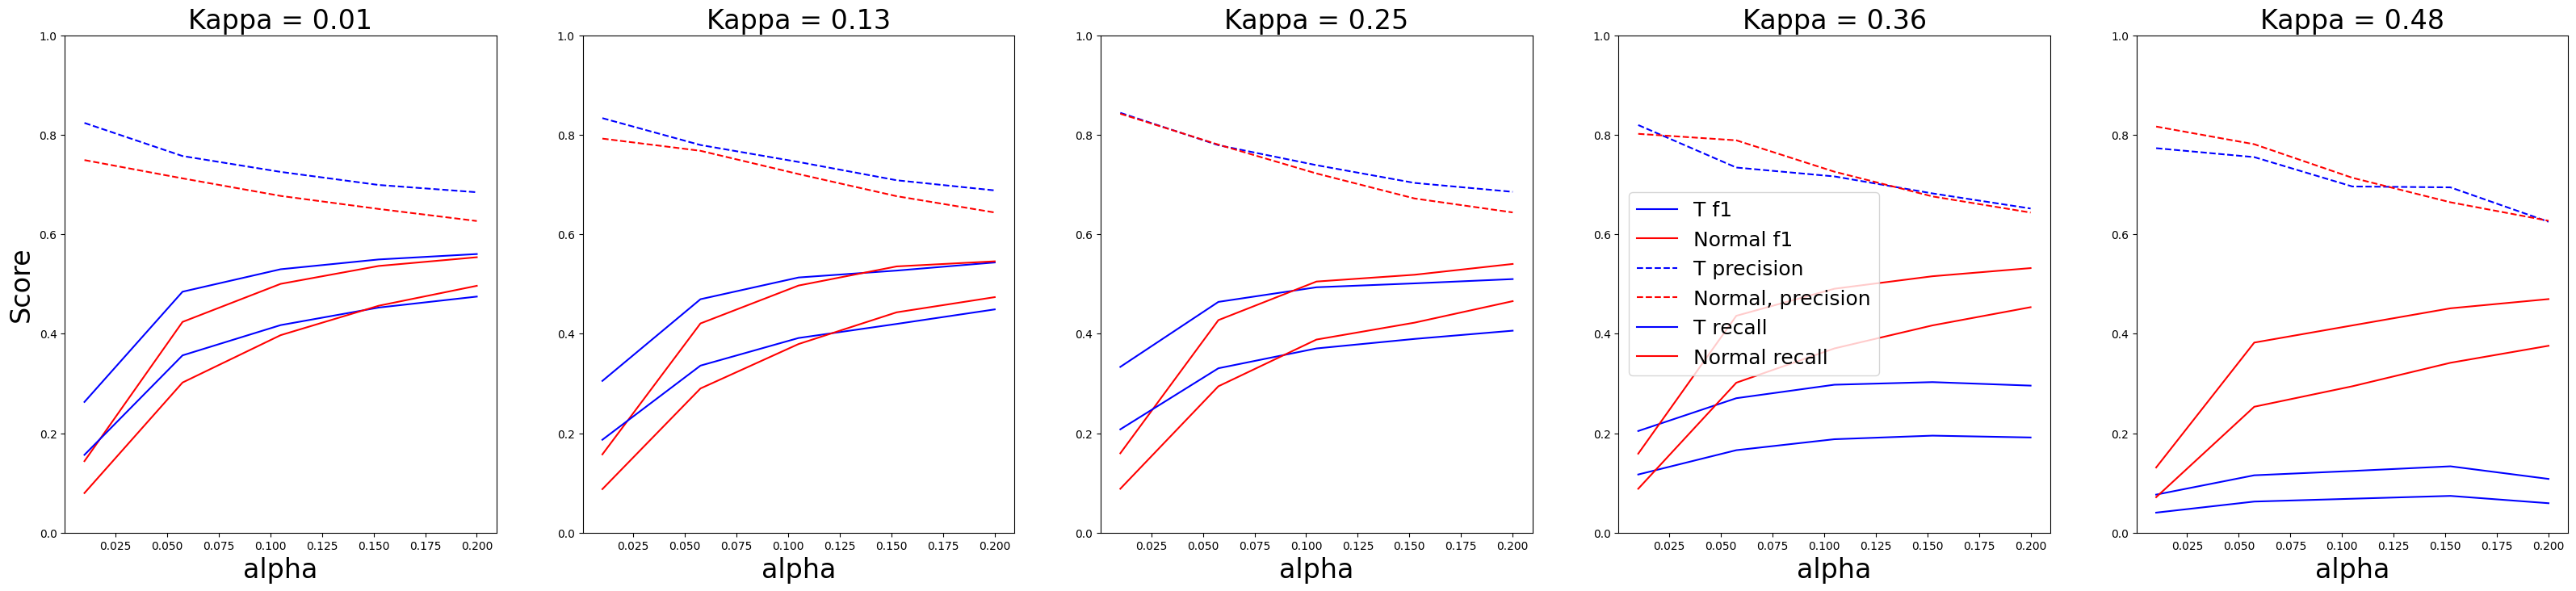

In [26]:
fig, ax = plt.subplots(1,5, figsize = (40,8))
out_dict = all_dicts[2]
for i,k_idx in enumerate([0,1,2,3,4]):

    ax[i].plot(out_dict['alpha'],out_dict['f1_t'][k_idx], label = 'T f1', color = 'blue')
    ax[i].plot(out_dict['alpha'],out_dict['f1_n'][k_idx], label = 'Normal f1', color = 'red')

    ax[i].plot(out_dict['alpha'],out_dict['prec_t'][k_idx], label = 'T precision', color = 'blue', linestyle = 'dashed')
    ax[i].plot(out_dict['alpha'],out_dict['prec_n'][k_idx], label = 'Normal, precision', color = 'red', linestyle = 'dashed')

    ax[i].plot(out_dict['alpha'],out_dict['recall_t'][k_idx], label = 'T recall', color = 'blue')
    ax[i].plot(out_dict['alpha'],out_dict['recall_n'][k_idx], label = 'Normal recall', color = 'red')

    #ax.plot(out_dict['alpha'],out_dict['bal_acc_t'][k_idx], label = 'T bal. acc.', color = 'blue', linestyle = (0, (3, 5, 1, 5, 1, 5)))
    #ax.plot(out_dict['alpha'],out_dict['bal_acc_n'][k_idx], label = 'Normal bal. acc.', color = 'red', linestyle = (0, (3, 5, 1, 5, 1, 5)))

    #ax[i].plot(out_dict['alpha'],out_dict['auc_t'][k_idx], label = 'T auc', color = 'blue')
    #ax[i].plot(out_dict['alpha'],out_dict['auc_n'][k_idx], label = 'Normal auc', color = 'red')

    ax[i].set_xlabel("alpha", fontdict= {'fontsize':24})
    if i == 0:
        ax[i].set_ylabel("Score", fontdict= {'fontsize':24})
    ax[i].set_title(f"Kappa = {np.round(out_dict['kappa'][k_idx],2)}", fontdict = {'fontsize':24})
    ax[i].set_ylim([0,1])

    if i == 4-1:
        legend  = ax[i].legend(title = "",fontsize = 18)
        legend.get_title().set_fontsize('18')

# Single test

In [40]:
d = 10
alpha_prob =  0.2 #[0.03, 0.15, 0.5, 0.7, 0.8, 0.9, 0.95, 0.97, 0.99 ]
alphas = np.linspace(0.01, 0.2, 3)
kappas = [0.1]# np.linspace(0.01, 0.6, 10)
tol = 1e-6
n = 10000
obs_per_graph = 1000

prec1 = make_sparse_spd_matrix(d, alpha=alpha_prob, smallest_coef=-0.9, largest_coef=0.9, norm_diag = True, random_state = 42)
prec2 = make_sparse_spd_matrix(d, alpha=alpha_prob, smallest_coef=-0.9, largest_coef=0.9, norm_diag = True, random_state = 412)
prec3 = make_sparse_spd_matrix(d, alpha=alpha_prob, smallest_coef=-0.9, largest_coef=0.9, norm_diag = True, random_state = 452)
prec4 = make_sparse_spd_matrix(d, alpha=alpha_prob, smallest_coef=-0.9, largest_coef=0.9, norm_diag = True, random_state = 462)
prec = np.block([[prec1, np.zeros((d,3*d))], 
                 [np.zeros((d,d)), prec2, np.zeros((d,2*d))],
                 [np.zeros((d,2*d)), prec3, np.zeros((d,d))],
                 [np.zeros((d,3*d)), prec4]])
# prec = prec1
tmp = prec.copy()
np.fill_diagonal(tmp,0)
G = nx.from_numpy_array(tmp)
print(nx.density(G))
print("\n")
nus = [4]

pbar = tqdm.tqdm(total = len(alphas)*len(kappas)*len(nus))

for nu in nus:
    X1 = mvt.rvs(shape = np.linalg.inv(prec),  df = nu, size = n) # np.random.multivariate_normal(mean = np.zeros(prec.shape[0]),cov = np.linalg.inv(prec), size = n)
    X = X1
    prec_dict ={}

    dens_t = {i: [] for i in range(len(kappas))}
    time_t = {i: [] for i in range(len(kappas))}
    F_t = {i: [] for i in range(len(kappas))}
    f1_t = {i: [] for i in range(len(kappas))}
    zo_t = {i: [] for i in range(len(kappas))}
    l1_t = {i: [] for i in range(len(kappas))}
    theta_t = {i: [] for i in range(len(kappas))}

    dens_n = {i: [] for i in range(len(kappas))}
    time_n = {i: [] for i in range(len(kappas))}
    F_n = {i: [] for i in range(len(kappas))}
    zo_n = {i: [] for i in range(len(kappas))}
    l1_n = {i: [] for i in range(len(kappas))}
    f1_n = {i: [] for i in range(len(kappas))}
    theta_n = {i: [] for i in range(len(kappas))}

    for i, kappa in enumerate(kappas):
        for alpha in alphas:



            start = time.time()
            dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 10000, lamda = obs_per_graph*alpha, kappa = obs_per_graph*kappa, tol = tol)
            dg_opt1.fit(X, nr_workers=1, temporal_penalty="element-wise", lik_type="t", nr_em_itr = 1, time_index=range(X.shape[0]), nu = nu, em_tol = 1e-10, verbose =False)
            elapsed = time.time()-start
            dens_t[i].append(nx.density(G))
            time_t[i].append(elapsed)
            theta_t[i].append(dg_opt1.theta)

            zo_t[i].append(np.mean([calc_one_zero_error(prec, dg_opt1.theta[k]) for k in range(len(dg_opt1.theta))]))
            F_t[i].append(np.mean([scipy.linalg.norm(prec-dg_opt1.theta[k], ord = 'fro')/scipy.linalg.norm(prec, ord = 'fro') for k in range(len(dg_opt1.theta))]))
            l1_t[i].append(np.mean([scipy.linalg.norm(prec-dg_opt1.theta[k], ord = 1)/scipy.linalg.norm(prec, ord = 1) for k in range(len(dg_opt1.theta))]))
            f1_t[i].append(np.mean([calc_f1(prec, dg_opt1.theta[k]) for k in range(len(dg_opt1.theta))]))

            start = time.time()
            dg_opt_n = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 10000, lamda = obs_per_graph*alpha, kappa = obs_per_graph*kappa, tol = tol)
            dg_opt_n.fit(X, nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian", time_index=range(X.shape[0]), verbose =False)
            elapsed = time.time()-start
            dens_n[i].append(nx.density(G))
            time_n[i].append(elapsed)
            theta_n[i].append(dg_opt_n.theta)

            zo_n[i].append(np.mean([calc_one_zero_error(prec, dg_opt_n.theta[k]) for k in range(len(dg_opt_n.theta))]))
            F_n[i].append(np.mean([scipy.linalg.norm(prec-dg_opt_n.theta[k], ord = 'fro')/scipy.linalg.norm(prec, ord = 'fro') for k in range(len(dg_opt_n.theta))]))
            l1_n[i].append(np.mean([scipy.linalg.norm(prec-dg_opt_n.theta[k], ord = 1)/scipy.linalg.norm(prec, ord = 1) for k in range(len(dg_opt_n.theta))]))
            f1_n[i].append(np.mean([calc_f1(prec, dg_opt_n.theta[k]) for k in range(len(dg_opt_n.theta))]))
            pbar.update()

        out_dict = {'nr_obs_per_graph':obs_per_graph, 'n':n, 'temporal_penalty':'global-reconstruction', 'prec':prec,
        'density_t':dens_t, 'tol':tol, 'time_t':time_t, 'zo_t':zo_t, 'F_t':F_t, 'l1_t':l1_t, 'theta_t':theta_t, 'f1_t':f1_t,
        'density_n':dens_n,  'time_n':time_n, 'zo_n':zo_n, 'F_n':F_n, 'l1_n':l1_n, 'theta_n':theta_n, 'f1_n':f1_n,
        'alpha':alphas, 'kappa':kappas, 'max_iter':5000} 

0.11538461538461539




100%|██████████| 3/3 [00:49<00:00, 16.38s/it]
C:\Users/User/Code/DyGraph\DyGraph\dygl_parallel.py:111: UserWarning: EM algorithm did not converge. Try to increase number of iterations
  warnings.warn("EM algorithm did not converge. Try to increase number of iterations")
 33%|███▎      | 1/3 [01:18<02:36, 78.29s/it]C:\Users/User/Code/DyGraph\DyGraph\dygl_parallel.py:111: UserWarning: EM algorithm did not converge. Try to increase number of iterations
  warnings.warn("EM algorithm did not converge. Try to increase number of iterations")
 67%|██████▋   | 2/3 [02:30<01:14, 74.86s/it]C:\Users/User/Code/DyGraph\DyGraph\dygl_parallel.py:111: UserWarning: EM algorithm did not converge. Try to increase number of iterations
  warnings.warn("EM algorithm did not converge. Try to increase number of iterations")
100%|██████████| 3/3 [03:28<00:00, 66.96s/it]

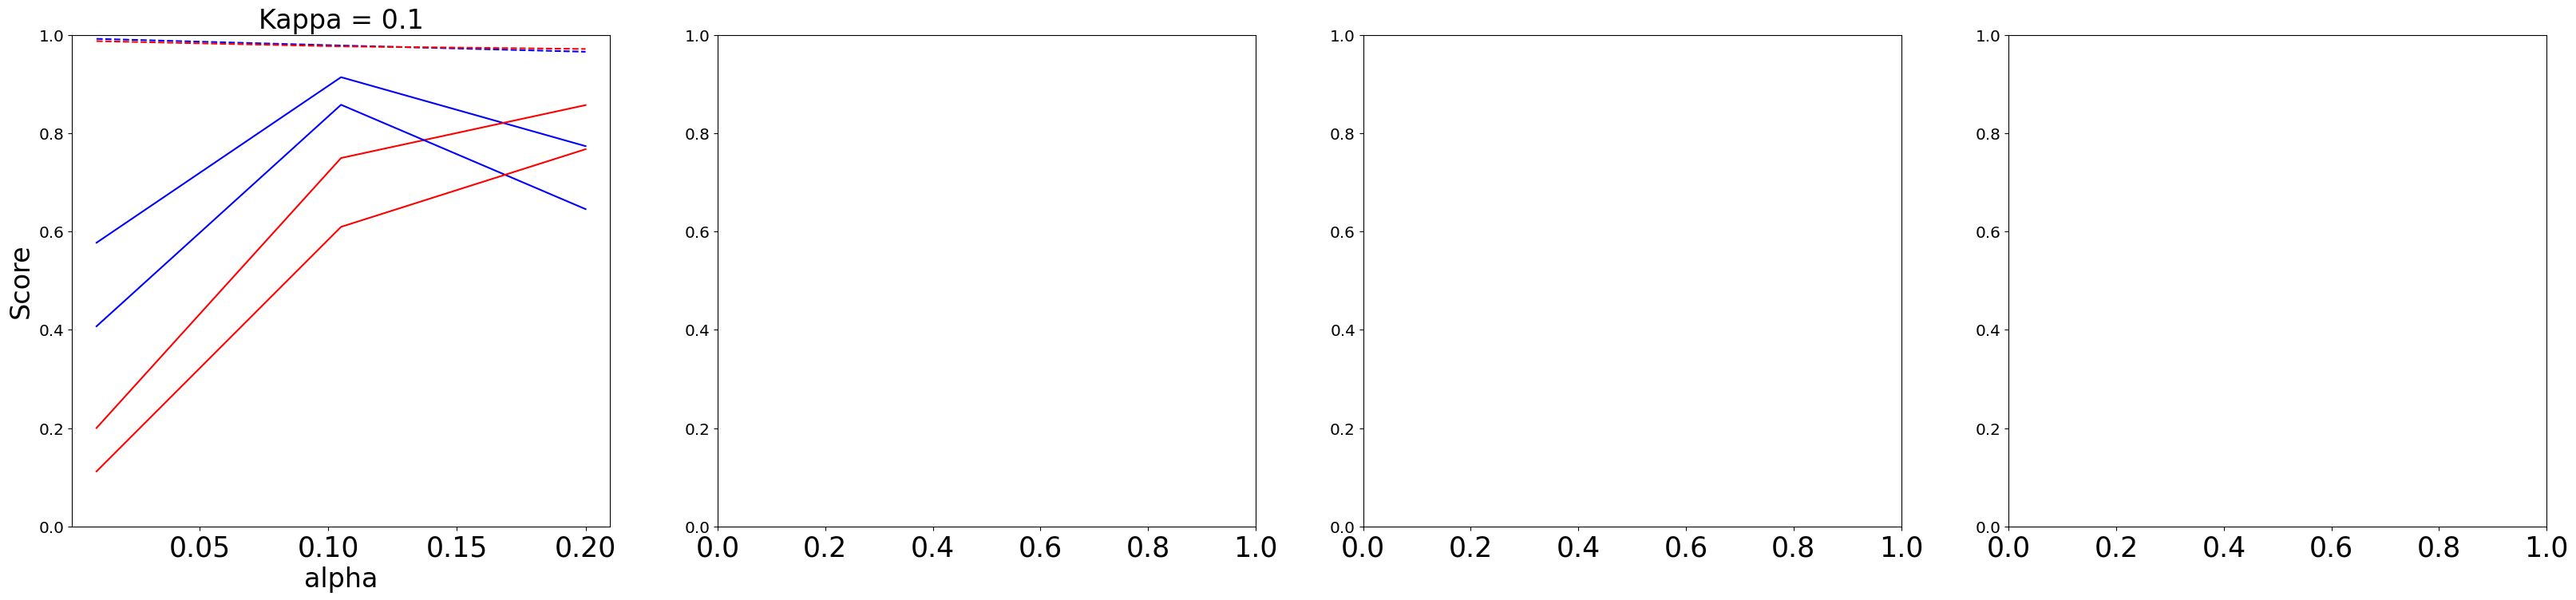

In [42]:
fig, ax = plt.subplots(1,4, figsize = (40,8))
for i,k_idx in enumerate([0]):

    ax[i].plot(out_dict['alpha'],out_dict['f1_t'][k_idx], label = 'T f1', color = 'blue')
    ax[i].plot(out_dict['alpha'],out_dict['f1_n'][k_idx], label = 'Normal f1', color = 'red')

    ax[i].plot(out_dict['alpha'],out_dict['prec_t'][k_idx], label = 'T precision', color = 'blue', linestyle = 'dashed')
    ax[i].plot(out_dict['alpha'],out_dict['prec_n'][k_idx], label = 'Normal, precision', color = 'red', linestyle = 'dashed')

    ax[i].plot(out_dict['alpha'],out_dict['recall_t'][k_idx], label = 'T recall', color = 'blue')
    ax[i].plot(out_dict['alpha'],out_dict['recall_n'][k_idx], label = 'Normal recall', color = 'red')

    #ax.plot(out_dict['alpha'],out_dict['bal_acc_t'][k_idx], label = 'T bal. acc.', color = 'blue', linestyle = (0, (3, 5, 1, 5, 1, 5)))
    #ax.plot(out_dict['alpha'],out_dict['bal_acc_n'][k_idx], label = 'Normal bal. acc.', color = 'red', linestyle = (0, (3, 5, 1, 5, 1, 5)))

    #ax[i].plot(out_dict['alpha'],out_dict['auc_t'][k_idx], label = 'T auc', color = 'blue')
    #ax[i].plot(out_dict['alpha'],out_dict['auc_n'][k_idx], label = 'Normal auc', color = 'red')

    ax[i].set_xlabel("alpha", fontdict= {'fontsize':24})
    if i == 0:
        ax[i].set_ylabel("Score", fontdict= {'fontsize':24})
    ax[i].set_title(f"Kappa = {np.round(out_dict['kappa'][k_idx],2)}", fontdict = {'fontsize':24})
    ax[i].set_ylim([0,1])

    if i == 4-1:
        legend  = ax[i].legend(title = "",fontsize = 18)
        legend.get_title().set_fontsize('18')

# Plot nu

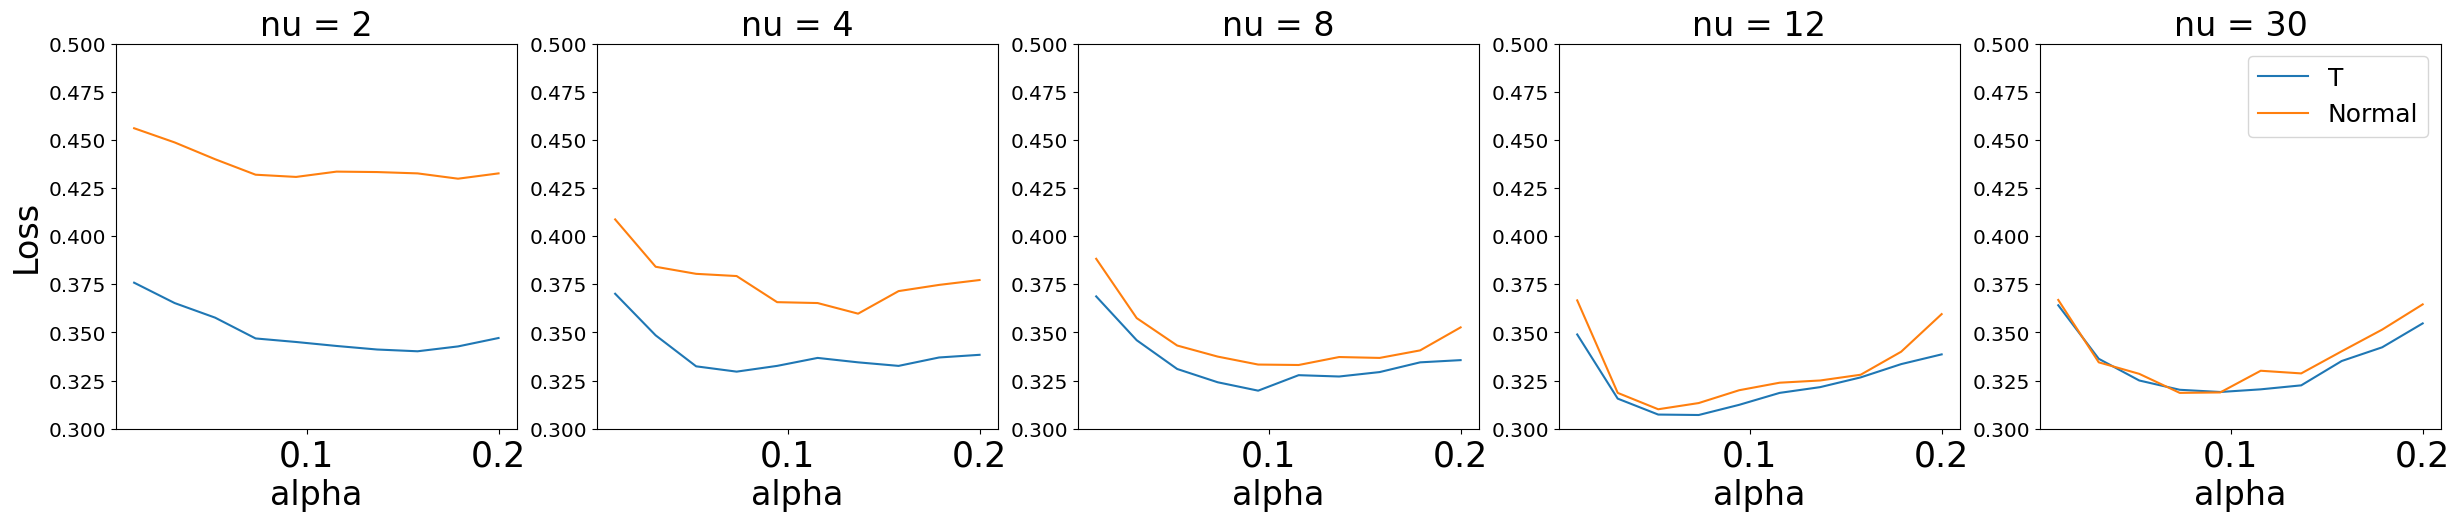

In [29]:
fig, ax = plt.subplots(1,5, figsize = (30,5))
for cnt, nu in enumerate([2,4,8, 12,30]):

    with open(f'../data/distributions/mvt_mvt_gaussian_search_d_30_n_1000_s_0.9_nu_{nu}.pkl', 'rb') as handle:
        out_dict = pickle.load(handle)


    ax[cnt].plot(out_dict['alpha'],out_dict['zo_t'][3][::2], label = 'T')
    ax[cnt].plot(out_dict['alpha'],out_dict['zo_t'][3][1::2], label = 'Normal')
    ax[cnt].set_xlabel("alpha", fontdict= {'fontsize':24})
    if cnt == 0:
        ax[cnt].set_ylabel("Loss", fontdict= {'fontsize':24})
    ax[cnt].set_title(f"nu = {nu}", fontdict = {'fontsize':24})
    ax[cnt].set_ylim([0.3,0.5])
    if cnt ==4:
        
        legend  = ax[4].legend(title = "",fontsize = 18, bbox_to_anchor = (1,1))
        legend.get_title().set_fontsize('18')
        

In [60]:
out_dict['zo_n'][1]

[0.4537142857142856,
 0.4120816326530613,
 0.39224489795918366,
 0.38318367346938775,
 0.38016326530612243,
 0.38285714285714284,
 0.3838367346938776,
 0.38791836734693874,
 0.40228571428571425,
 0.4106938775510204]

0.5559183673469388


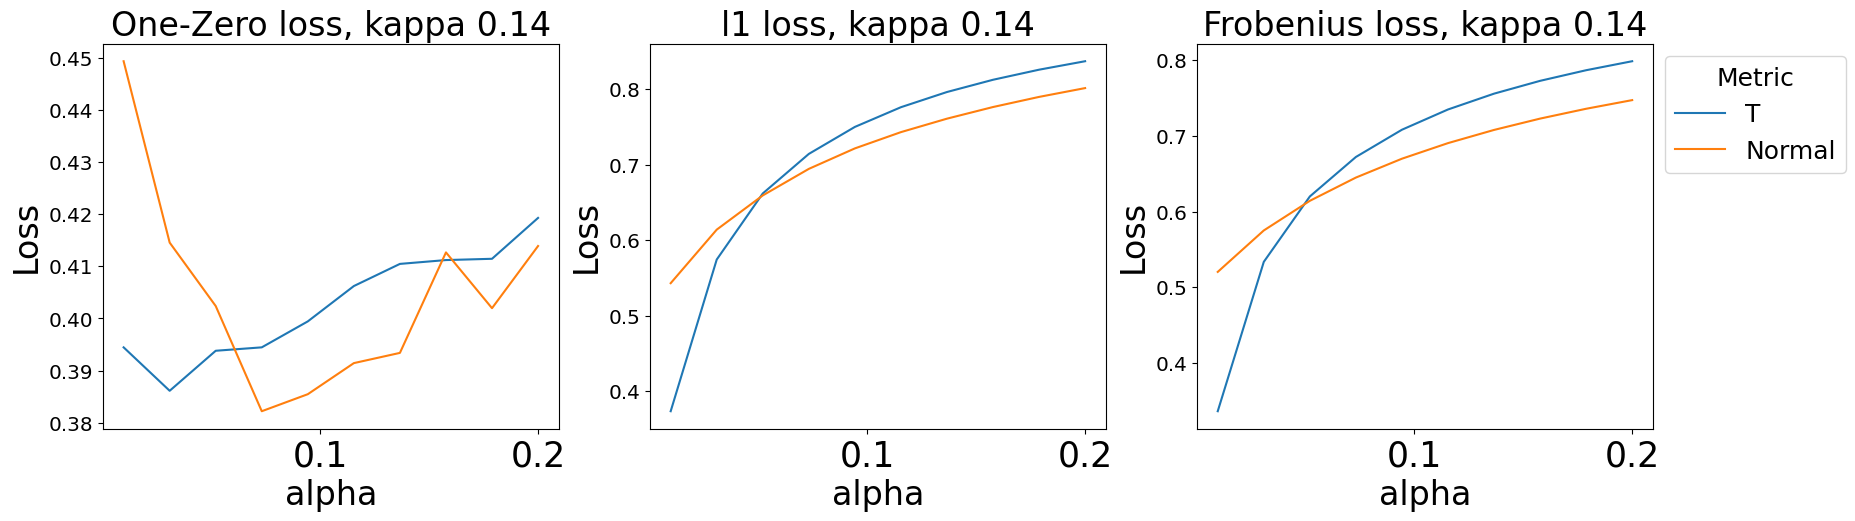

In [65]:
with open(f'../data/distributions/mvt_mvt_gaussian_search_d_50_n_10000.pkl', 'rb') as handle:
    out_dict = pickle.load(handle)


if 'density_inner' in out_dict.keys():
    out_dict['density_t'] = out_dict['density_inner']
    out_dict['l1_t'] = out_dict['l1_inner']
    out_dict['F_t'] = out_dict['F_inner']
    out_dict['zo_t'] = out_dict['zo_inner']
    out_dict['density_n'] = out_dict['density_outer']
    out_dict['l1_n'] = out_dict['l1_outer']
    out_dict['F_n'] = out_dict['F_outer']
    out_dict['zo_n'] = out_dict['zo_outer']


print(out_dict['density_t'][0][0])

k_idx = 4


# out_dict['f1_n'] = {i: [] for i in range(len(out_dict['theta_n']))}
# out_dict['f1_t'] = {i: [] for i in range(len(out_dict['theta_n']))}
# for i in range(len(out_dict['theta_n'])):
#     for j in range(len(out_dict['theta_n'][0])):
#         out_dict['f1_n'][i].append(np.mean([calc_f1(out_dict['prec'], out_dict['theta_n'][i][j][k]) for k in range(len(dg_opt_n.theta))]))
#         out_dict['f1_t'][i].append(np.mean([calc_f1(out_dict['prec'], out_dict['theta_t'][i][j][k]) for k in range(len(dg_opt_n.theta))]))

bbox_to_anchor = (1,1)

fig, ax = plt.subplots(1,3, figsize = (20,5))

ax[0].plot(out_dict['alpha'],out_dict['zo_t'][k_idx], label = 'T')
ax[0].plot(out_dict['alpha'],out_dict['zo_n'][k_idx], label = 'Normal')
ax[0].set_xlabel("alpha", fontdict= {'fontsize':24})
ax[0].set_ylabel("Loss", fontdict= {'fontsize':24})
ax[0].set_title(f"One-Zero loss, kappa {np.round(out_dict['kappa'][k_idx],2)}", fontdict = {'fontsize':24})

#legend  = ax[0].legend(title = "Metric",fontsize = 18, bbox_to_anchor = bbox_to_anchor)
#legend.get_title().set_fontsize('18')

ax[1].plot(out_dict['alpha'],out_dict['l1_t'][k_idx], label = 'T')
ax[1].plot(out_dict['alpha'],out_dict['l1_n'][k_idx], label = 'Normal')
ax[1].set_xlabel("alpha", fontdict= {'fontsize':24})
ax[1].set_ylabel("Loss", fontdict= {'fontsize':24})
ax[1].set_title(f"l1 loss, kappa {np.round(out_dict['kappa'][k_idx],2)}", fontdict = {'fontsize':24})

ax[2].plot(out_dict['alpha'],out_dict['F_t'][k_idx], label = 'T')
ax[2].plot(out_dict['alpha'],out_dict['F_n'][k_idx], label = 'Normal')
ax[2].set_xlabel("alpha", fontdict= {'fontsize':24})
ax[2].set_ylabel("Loss", fontdict= {'fontsize':24})
ax[2].set_title(f"Frobenius loss, kappa {np.round(out_dict['kappa'][k_idx],2)}", fontdict = {'fontsize':24})



legend  = ax[2].legend(title = "Metric",fontsize = 18, bbox_to_anchor = bbox_to_anchor)
legend.get_title().set_fontsize('18')

In [13]:
out_dict['prec'].shape

(50, 50)

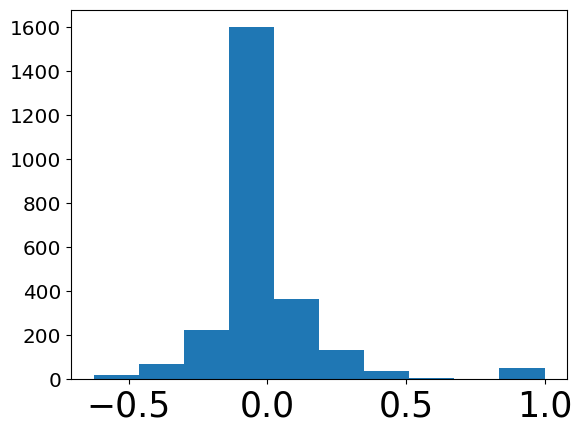

In [14]:
_ = plt.hist(prec.flatten())

In [21]:
alpha = 0.1
kappa = 0.1
d = 30
alpha_prob = 0.9
n = 1000
obs_per_graph = 100
tol = 1e-6
prec = make_sparse_spd_matrix(d, alpha=alpha_prob, smallest_coef=-0.9, largest_coef=0.9, norm_diag = True, random_state = 42)
tmp = prec.copy()
np.fill_diagonal(tmp,0)
G = nx.from_numpy_array(tmp)
print(nx.density(G))
print("\n")


X1 = mvt.rvs(shape = np.linalg.inv(prec),  df = 4, size = n) # np.random.multivariate_normal(mean = np.zeros(prec.shape[0]),cov = np.linalg.inv(prec), size = n)
X = X1

start = time.time()
dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 10000, lamda = obs_per_graph*alpha, kappa = obs_per_graph*kappa, tol = tol)
dg_opt1.fit(X, nr_workers=1, temporal_penalty="element-wise", lik_type="t", nr_em_itr = 1, time_index=range(X.shape[0]), nu = 4, em_tol = 1e-6, verbose =True)
elapsed = time.time()-start


print(np.mean([calc_one_zero_error(prec, dg_opt1.theta[k]) for k in range(len(dg_opt1.theta))]))
print(np.mean([scipy.linalg.norm(prec-dg_opt1.theta[k], ord = 'fro')/scipy.linalg.norm(prec, ord = 'fro') for k in range(len(dg_opt1.theta))]))
print(np.mean([scipy.linalg.norm(prec-dg_opt1.theta[k], ord = 1)/scipy.linalg.norm(prec, ord = 1) for k in range(len(dg_opt1.theta))]))
    
start = time.time()
dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 10000, lamda = obs_per_graph*alpha, kappa = obs_per_graph*kappa, tol = tol)
dg_opt1.fit(X, nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian", time_index=range(X.shape[0]), verbose =True)
elapsed = time.time()-start

print(np.mean([calc_one_zero_error(prec, dg_opt1.theta[k]) for k in range(len(dg_opt1.theta))]))
print(np.mean([scipy.linalg.norm(prec-dg_opt1.theta[k], ord = 'fro')/scipy.linalg.norm(prec, ord = 'fro') for k in range(len(dg_opt1.theta))]))
print(np.mean([scipy.linalg.norm(prec-dg_opt1.theta[k], ord = 1)/scipy.linalg.norm(prec, ord = 1) for k in range(len(dg_opt1.theta))]))

0.20919540229885059




Error 1.00E-6:  10%|▉         | 978/10000 [00:06<00:57, 158.13it/s]


0.41287356321839086
0.5030141269225543
0.6202083681741765


Error 1.01E-6:   5%|▍         | 458/10000 [00:01<00:29, 328.85it/s]

0.5158620689655172
0.5098586702673713
0.6382704670198065
